# Investigating Fandango's Movie Ratings

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com/) is an online movie ratings aggregator). He published his analysis in [this article](https://fivethirtyeight.com/features/fandango-movies-ratings/) — a great piece of data journalism that's totally worth reading.

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

* The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
* In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
* For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

Fandango's officials replied saying the rounding off was caused by a bug in their system rather than being intentional.

In this project, I will analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

I will be using the data Hickey collected, as well as data collected by Dataquest which are movie ratings for movies released in 2016 and 2017.

In [25]:
import pandas as pd

# read in both files
fandango_scores = pd.read_csv(r'C:\Users\chizj\Downloads\DataQuest CSVs\fandango_score_comparison.csv')
new_movie_ratings = pd.read_csv(r'C:\Users\chizj\Downloads\DataQuest CSVs\movie_ratings_16_17.csv')

fandango_scores.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [26]:
new_movie_ratings.head(3)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.5,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.0,2.35,2.5,3.5,2.0,2.5


In [27]:
# isolate the columns that offer the information about Fandango's ratings 
# so it's more readily available for later use
old_movies = fandango_scores[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue',
                            'Fandango_votes', 'Fandango_Difference']]
new_movies = new_movie_ratings[['movie', 'year', 'fandango']]

old_movies.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [28]:
new_movies.head(3)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


Our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis. The population of interest for our analysis is made of all the movie ratings stored on Fandango's website, regardless of the releasing year.

Because we want to find out whether the parameters of this population changed after Hickey's analysis, we're interested in sampling the population at two different periods in time — previous and after Hickey's analysis — so we can compare the two states.

The data we're working with was sampled at the moments we want: one sample was taken previous to the analysis, and the other after the analysis. We want to describe the population, so we need to make sure that the samples are representative, otherwise we should expect a large sampling error and, ultimately, wrong conclusions.

From Hickey's article and from the README.md of the [data set's repository](https://github.com/fivethirtyeight/data/tree/master/fandango), we can see that he used the following sampling criteria:

* The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
* The movie must have had tickets on sale in 2015.

The sampling was clearly not random because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

The sampling conditions for our other sample were (as it can be read in the README.md of the [data set's repository](https://github.com/mircealex/Movie_ratings_2016_17)):

* The movie must have been released in 2016 or later.
* The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data).

This second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest.

## Changing the goal of my analysis

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal.

## Isolating the Samples We Need

With this new research goal, we have two populations of interest:

* All Fandango's ratings for popular movies released in 2015.
* All Fandango's ratings for popular movies released in 2016.

We need to be clear about what counts as popular movies. We'll use Hickey's benchmark of 30 fan ratings and count a movie as popular only if it has 30 fan ratings or more on Fandango's website.

Although one of the sampling criteria in our second sample is movie popularity, the sample doesn't provide information about the number of fan ratings. We should be skeptical once more and ask whether this sample is truly representative and contains popular movies (movies with over 30 fan ratings).

One quick way to check the representativity of this sample is to sample randomly 10 movies from it and then check the number of fan ratings ourselves on Fandango's website. Ideally, at least 8 out of the 10 movies have 30 fan ratings or more.

In [29]:
new_movies.sample(10, random_state=1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


I randomly chose 10 movies from the new_movies dataset which you can see above. I checked on the current number of Fandango fan ratings for each movie as of April 2018. The data is as follows:

In [30]:
user_reviews = {'Movie':['Mechanic: Resurrection', 'Warcraft',
               'Max Steel', 'Me Before You', 'Fantastic Beasts and Where to Find Them',
               'Cell', 'Genius', 'Sully', 'A Hologram for the King',
               'Captain America: Civil War'],
               'Fan ratings':[2247, 7271, 493, 5263, 13400, 17, 127, 11877, 500, 35057]}

fan_ratings = pd.DataFrame(user_reviews)
fan_ratings.style.hide_index()

Movie,Fan ratings
Mechanic: Resurrection,2247
Warcraft,7271
Max Steel,493
Me Before You,5263
Fantastic Beasts and Where to Find Them,13400
Cell,17
Genius,127
Sully,11877
A Hologram for the King,500
Captain America: Civil War,35057


From this sample 90% of the movies have over 30 user reviews on Fandango. I'll quickly check the old_movies dataset for the same thing.

In [31]:
sum(old_movies['Fandango_votes'] < 30)

0

As expected, every single movie in the old_movies dataset has over 30 user reviews. This means we can use both of these datasets for our analysis.

I will now isolate movies that were released in 2015 and 2016 into seperate datasets.

In [32]:
# separating new_movies
new_movies_2015 = new_movies[new_movies['year'] == 2015]
new_movies_2016 = new_movies[new_movies['year'] == 2016]
fandango_2016 = new_movies_2016

In [33]:
# separating old_movies; there is no column but we can extract the year from the name column
old_movies['Year'] = old_movies['FILM'].str.extract('\((\d{4})\)').astype(int)

C:\Users\chizj\Anaconda3\envs\Classes\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
old_movies['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [35]:
# select only movies from 2015
fandango_2015 = old_movies[old_movies['Year'] == 2015].copy()

In [36]:
fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

In [37]:
fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

## Comparing Distribution Shapes for 2015 and 2016

Our aim is to figure out whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.

We'll start with comparing the shape of the two distributions using kernel density plots. I will use the fivethirtyeight style for the plots.

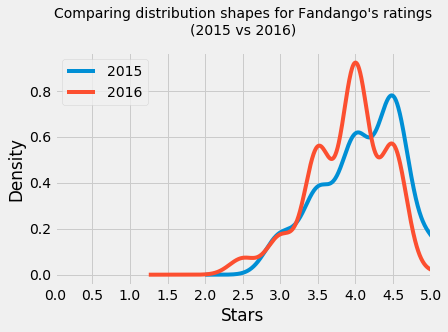

In [38]:
import matplotlib.pyplot as plt
from numpy import arange

plt.style.use('fivethirtyeight')

fandango_2015['Fandango_Stars'].plot.kde(legend=True, label=2015)
fandango_2016['fandango'].plot.kde(legend=True, label=2016)

plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)",
         y=1.05, fontsize=14)
plt.xlabel('Stars')
plt.ylabel('Density')
plt.xlim(0,5)
plt.xticks(arange(0, 5.1, step=0.5))
plt.show()


Two aspects are striking on the figure above:

* Both distributions are strongly left skewed.
* The 2016 distribution is slightly shifted to the left relative to the 2015 distribution.

The left skew suggests that movies on Fandango are given mostly high and very high fan ratings. Coupled with the fact that Fandango sells tickets, the high ratings are a bit dubious. It'd be really interesting to investigate this further — ideally in a separate project, since this is quite irrelevant for the current goal of our analysis.

The slight left shift of the 2016 distribution is very interesting for our analysis. It shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016

## Comparing Relative Frequencies¶

It seems we're following a good thread so far, but we need to analyze more granular information. Let's examine the frequency tables of the two distributions to analyze some numbers. Because the data sets have different numbers of movies, we normalize the tables and show percentages instead.

In [39]:
fandango_2015['Fandango_Stars'].value_counts(normalize=True).sort_index(ascending=False) * 100

5.0     6.976744
4.5    37.984496
4.0    28.682171
3.5    17.829457
3.0     8.527132
Name: Fandango_Stars, dtype: float64

In [40]:
fandango_2016['fandango'].value_counts(normalize=True).sort_index(ascending=False) * 100

5.0     0.523560
4.5    24.607330
4.0    40.314136
3.5    24.083770
3.0     7.329843
2.5     3.141361
Name: fandango, dtype: float64

In 2016, very high ratings (4.5 and 5 stars) had significantly lower percentages compared to 2015. In 2016, under 1% of the movies had a perfect rating of 5 stars, compared to 2015 when the percentage was close to 7%. Ratings of 4.5 were also more popular in 2015 — there were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

The minimum rating is also lower in 2016 — 2.5 instead of 3 stars, the minimum of 2015. There clearly is a difference between the two frequency distributions.

For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings and this challenges the direction of the change we saw on the kernel density plots.

## Determining the Direction of the Change

Let's take a couple of summary metrics to get a more precise picture about the direction of the change. In what follows, we'll compute the mean, the median, and the mode for both distributions and then use a bar graph to plot the values.

In [68]:
mean2015 = fandango_2015['Fandango_Stars'].mean()
mean2016 = fandango_2016['fandango'].mean()

median2015 = fandango_2015['Fandango_Stars'].median()
median2016 = fandango_2016['fandango'].median()

mode2015 = fandango_2015['Fandango_Stars'].mode()[0] # used [0] becuase the output for .mode() is a bit different
mode2016 = fandango_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean2015, median2015, mode2015]
summary['2016'] = [mean2016, median2016, mode2016]
summary.index = ['mean', 'median', 'mode']

summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


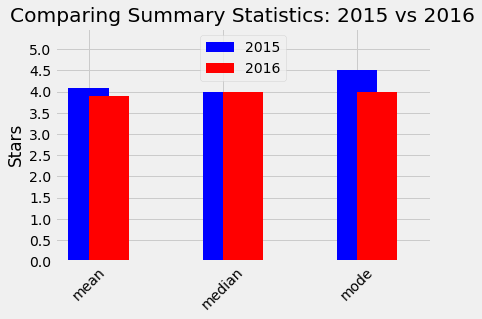

In [99]:
plt.style.use('fivethirtyeight')

summary['2015'].plot.bar(x=summary.index, align='center', color='blue', legend=True, label='2015', width=0.3)
summary['2016'].plot.bar(x=summary.index, align='edge', color='red', legend=True, label='2016', width=0.3)

plt.ylim(0, 5.5)
plt.yticks(arange(0, 5.5, step=0.5))
plt.ylabel('Stars')
plt.xticks(rotation=45)
plt.legend(loc='upper center')
plt.title('Comparing Summary Statistics: 2015 vs 2016')
plt.show()


The mean rating was lower in 2016 by approximately 0.2. This means a drop of almost 5% relative to the mean rating in 2015.

While the median is the same for both distributions, the mode is lower in 2016 by 0.5. Coupled with what we saw for the mean, the direction of the change we saw on the kernel density plot is confirmed: on average, popular movies released in 2016 were rated slightly lower than popular movies released in 2015.

## Conclusion

Our analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We cannot be completely sure what caused the change, but the chances are very high that it was caused by Fandango fixing the biased rating system after Hickey's analysis.